In [1]:
from matplotlib import pyplot as plt
import numpy as np
import random
from typing import Callable

MIN: int = 0
MAX: int = 4
BINS: int = 100
NUM_SAMPLES: int = 100000
N: int = 5

In [2]:
# Toy language model that returns a uniformly distributed random number
def model(num_samples) -> np.ndarray:
    return np.random.uniform(0, MAX, num_samples)

def histogram(output: list[int]):
    hist, bins = np.histogram(output, bins=BINS, range=(MIN, MAX), density=False)
    probs = hist / np.sum(hist)
    return probs, bins

In [3]:
# The ground truth reward model. We assume that we have a preference for the number `mid`.
def reward_model_ground_truth(output) -> float:
    # R(x) = 5 - |2 - x|
    return 5 - abs(2 - output)

# Definition of the proxy reward model. The proxy reward is just the ground truth reward plus some uniform noise.
def reward_model_proxy(output) -> float:
    noise = np.random.uniform(-0.5, 0.5)
    return reward_model_ground_truth(output) + noise

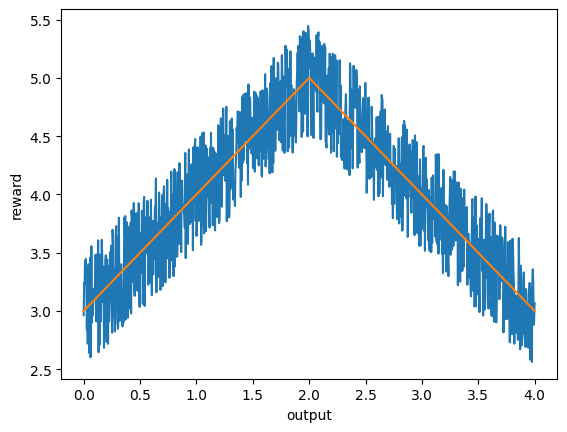

In [4]:
def plot_rewards() -> None:
    outputs = np.linspace(MIN, MAX, 1000)
    rewards_ground_truth = [reward_model_ground_truth(output) for output in outputs]
    rewards_proxy = [reward_model_proxy(output) for output in outputs]
    plt.plot(outputs, rewards_proxy, alpha=1.0)
    plt.plot(outputs, rewards_ground_truth, alpha=1.0)
    plt.xlabel("output")
    plt.ylabel("reward")

# Plot the proxy and ground truth rewards
plot_rewards()

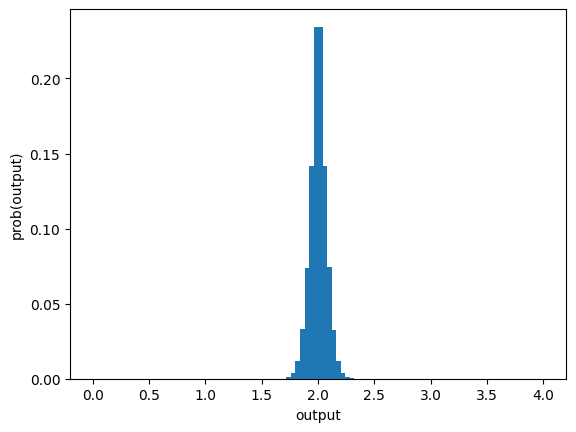

In [5]:
def best_of_n(n: int, reward_model):
    # Generate n samples from the model
    samples = model(n)
    
    # Score each sample with the reward model
    rewards = [reward_model(sample) for sample in samples]
    
    # Find the index of the best sample
    best_idx = np.argmax(rewards)
    
    # Return the best output and its reward
    return samples[best_idx], rewards[best_idx]


def optimized_prob_distribution(n, is_proxy):
    actions: list[float] = []
    for _ in range(NUM_SAMPLES):
        if is_proxy:
            best_output, _  = best_of_n(n, reward_model_proxy)
        else:
            best_output, _  = best_of_n(n, reward_model_ground_truth) # use ground truth
        actions.append(best_output)
    probs, bins = histogram(actions)
    return probs, bins

# Probabilities before best-of-n sampling
probs_initial: list[int] = BINS * [1/BINS]

# Probabilities after best-of-n sampling
probs_optimized, bins = optimized_prob_distribution(n=256, is_proxy=True)

def plot_optimized_output() -> None:
    plt.hist(bins[:-1], bins, weights=probs_optimized)
    plt.xlabel("output")
    plt.ylabel("prob(output)")

# Plot the output after best-of-n sampling using the proxy reward model
plot_optimized_output()

In [6]:
# The KL divergence for best-of-n sampling can be computed analytically, see page 31 https://arxiv.org/pdf/2009.01325.pdf
def kl_divergence_analytical(n):
    return np.log(n) - (n - 1) / n

def kl_divergence_numerical(p, q):
    # p is the optimized distribution, q is the initial distribution
    # KL(p||q) = sum(p * log(p/q))
    # Convert to numpy arrays if needed
    p = np.array(p)
    q = np.array(q)
    # Avoid log(0) by filtering out zero probabilities
    mask = p > 0
    return np.sum(p[mask] * np.log(p[mask] / q[mask]))

# The KL divergence between the initial distribution and the optimized distribution increases with n
for n in [2, 4, 8, 16, 32, 64, 128, 256]:
    probs_optimized, bins = optimized_prob_distribution(n, is_proxy=True)
    kl_analytical = kl_divergence_analytical(n)
    kl_numerical = kl_divergence_numerical(probs_optimized, probs_initial)
    print(f"n={n}, kl_divergence_analytical={kl_analytical:.4f}, kl_divergence_numerical={kl_numerical:.4f}")

n=2, kl_divergence_analytical=0.1931, kl_divergence_numerical=0.1487
n=4, kl_divergence_analytical=0.6363, kl_divergence_numerical=0.5024
n=8, kl_divergence_analytical=1.2044, kl_divergence_numerical=0.8892
n=16, kl_divergence_analytical=1.8351, kl_divergence_numerical=1.2429
n=32, kl_divergence_analytical=2.4970, kl_divergence_numerical=1.5798
n=64, kl_divergence_analytical=3.1745, kl_divergence_numerical=1.9144
n=128, kl_divergence_analytical=3.8598, kl_divergence_numerical=2.2519
n=256, kl_divergence_analytical=4.5491, kl_divergence_numerical=2.5912


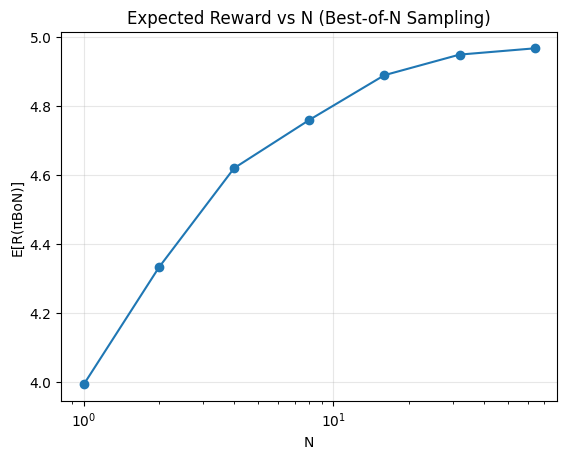

In [7]:
def estimate_reward(n:int, reward_model: Callable) -> float:
    # Run best_of_n multiple times and average the rewards
    total_reward = 0.0
    num_trials = 100  # As specified in the homework
    for _ in range(num_trials):
        _, reward = best_of_n(n, reward_model)
        total_reward += reward
    return total_reward / num_trials

rewards_ground_truth: list[float] = []

# N = 1,2,4,8,16,32,64 as specified in problem (b)
RANGE_N: list[int] = [1, 2, 4, 8, 16, 32, 64]
for n in RANGE_N:
    reward_ground_truth: float = estimate_reward(n, reward_model_ground_truth)
    rewards_ground_truth.append(reward_ground_truth)

# Plot E[R(πBoN)] vs N
plt.plot(RANGE_N, rewards_ground_truth, marker='o')
plt.xscale('log')
plt.ylabel('E[R(πBoN)]')
plt.xlabel('N')
plt.title('Expected Reward vs N (Best-of-N Sampling)')
plt.grid(True, alpha=0.3)
plt.show()

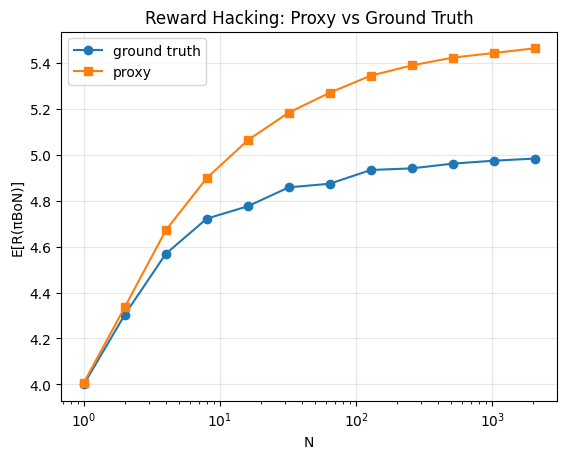

In [8]:
# why not using very large N?
# This demonstrates reward hacking: optimizing proxy leads to worse ground truth performance

def estimate_reward_both(n:int, reward_model_proxy_func: Callable) -> tuple[float, float]:
    # Run best_of_n using the PROXY reward model for selection
    # But evaluate the selected samples with BOTH proxy and ground truth
    total_reward_proxy = 0.0
    total_reward_ground_truth = 0.0
    num_trials = 100  # As specified in the homework
    for _ in range(num_trials):
        best_output, reward_proxy = best_of_n(n, reward_model_proxy_func)
        # Now evaluate this same output with ground truth
        reward_gt = reward_model_ground_truth(best_output)
        total_reward_proxy += reward_proxy
        total_reward_ground_truth += reward_gt
    return total_reward_proxy / num_trials, total_reward_ground_truth / num_trials

rewards_ground_truth: list[float] = []
rewards_proxy: list[float] = []

# Extended range to show divergence at large N
RANGE_N: list[int] = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048]
for n in RANGE_N:
    reward_proxy, reward_ground_truth = estimate_reward_both(n, reward_model_proxy)
    rewards_proxy.append(reward_proxy)
    rewards_ground_truth.append(reward_ground_truth)

# Plot proxy vs. ground truth rewards
plt.plot(RANGE_N, rewards_ground_truth, marker='o', label='ground truth')
plt.plot(RANGE_N, rewards_proxy, marker='s', label='proxy')
plt.xscale('log')
plt.ylabel('E[R(πBoN)]')
plt.xlabel('N')
plt.title('Reward Hacking: Proxy vs Ground Truth')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Problem 2: Best-of-N with Reward Hacking

## Part (a): Create proxy reward with boundary noise

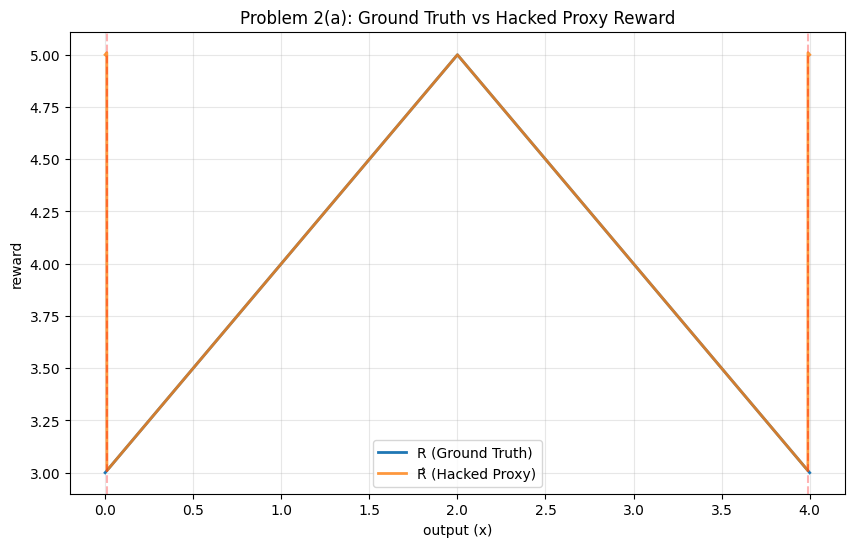

In [10]:
# Problem 2(a): Hacked proxy reward function
# Adds +2 noise at boundaries [0, 0.01] and [3.99, 4] to simulate reward hacking

def reward_model_proxy_hacked(output) -> float:
    """
    Proxy reward with boundary exploits:
    - R̂(x) = R(x) + 2 if x ∈ [0, 0.01] or [3.99, 4]
    - R̂(x) = R(x) otherwise
    """
    
    # Check if output is in the hacked boundary regions
    if (0 <= output <= 0.01) or (3.99 <= output <= 4):
        return reward_model_ground_truth(output) + 2  # Add boundary hack
    else:
        return reward_model_ground_truth(output)

# Plot both R (ground truth) and R̂ (hacked proxy)
def plot_rewards_hacked() -> None:
    outputs = np.linspace(MIN, MAX, 10000)  # More points to see boundary clearly
    rewards_ground_truth = [reward_model_ground_truth(output) for output in outputs]
    rewards_proxy_hacked = [reward_model_proxy_hacked(output) for output in outputs]
    
    plt.figure(figsize=(10, 6))
    plt.plot(outputs, rewards_ground_truth, label='R (Ground Truth)', linewidth=2)
    plt.plot(outputs, rewards_proxy_hacked, label='R̂ (Hacked Proxy)', linewidth=2, alpha=0.8)
    plt.xlabel("output (x)")
    plt.ylabel("reward")
    plt.title("Problem 2(a): Ground Truth vs Hacked Proxy Reward")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.axvline(x=0.01, color='r', linestyle='--', alpha=0.3, label='Boundary')
    plt.axvline(x=3.99, color='r', linestyle='--', alpha=0.3)
    plt.show()

plot_rewards_hacked()

## Part (b): Compute KL divergence with hacked proxy

Problem 2(b): KL Divergence with Hacked Proxy Reward Model
N=   1, KL_analytical=0.0000, KL_numerical=0.0005
N=   2, KL_analytical=0.1931, KL_numerical=0.1827
N=   4, KL_analytical=0.6363, KL_numerical=0.6110
N=   8, KL_analytical=1.2044, KL_numerical=1.1431
N=  16, KL_analytical=1.8351, KL_numerical=1.7243
N=  32, KL_analytical=2.4970, KL_numerical=2.2751
N=  64, KL_analytical=3.1745, KL_numerical=2.7469


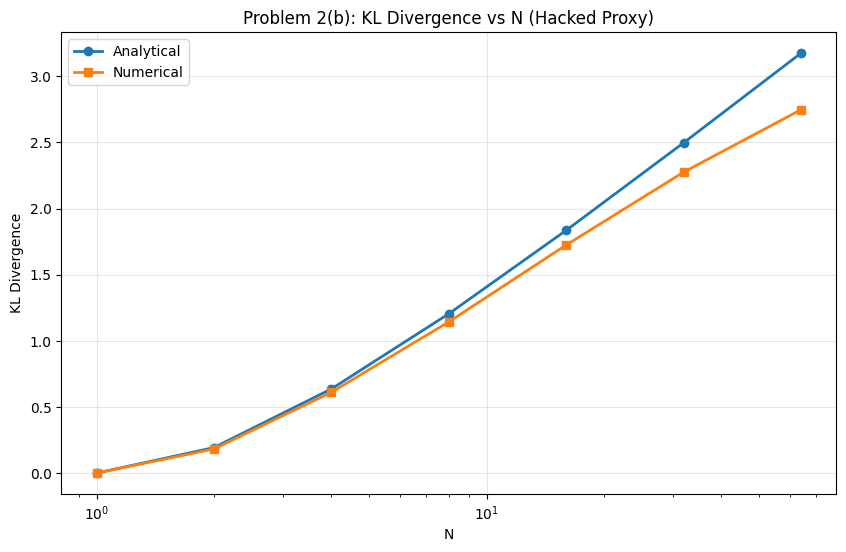

In [11]:
# Problem 2(b): KL divergence using hacked proxy for optimization

def optimized_prob_distribution_hacked(n):
    """Compute optimized distribution using hacked proxy reward model"""
    actions: list[float] = []
    for _ in range(NUM_SAMPLES):
        best_output, _ = best_of_n(n, reward_model_proxy_hacked)
        actions.append(best_output)
    probs, bins = histogram(actions)
    return probs, bins

print("Problem 2(b): KL Divergence with Hacked Proxy Reward Model")
print("=" * 70)

kl_results = []
for n in [1, 2, 4, 8, 16, 32, 64]:
    probs_optimized_hacked, bins = optimized_prob_distribution_hacked(n)
    kl_analytical = kl_divergence_analytical(n)
    kl_numerical = kl_divergence_numerical(probs_optimized_hacked, probs_initial)
    kl_results.append((n, kl_analytical, kl_numerical))
    print(f"N={n:4d}, KL_analytical={kl_analytical:.4f}, KL_numerical={kl_numerical:.4f}")

# Optional: Plot KL divergence vs N
plt.figure(figsize=(10, 6))
ns = [r[0] for r in kl_results]
kl_analytical_vals = [r[1] for r in kl_results]
kl_numerical_vals = [r[2] for r in kl_results]

plt.plot(ns, kl_analytical_vals, marker='o', label='Analytical', linewidth=2)
plt.plot(ns, kl_numerical_vals, marker='s', label='Numerical', linewidth=2)
plt.xscale('log')
plt.xlabel('N')
plt.ylabel('KL Divergence')
plt.title('Problem 2(b): KL Divergence vs N (Hacked Proxy)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Part (c): Demonstrate Reward Hacking

This part shows what happens when we optimize the hacked proxy reward at scale.
- **E[R̂(πBoN)]**: Expected reward according to the hacked proxy (what the optimizer sees)
- **E[R(πBoN)]**: Expected reward according to ground truth (actual performance)

At large N, the proxy reward keeps increasing, but ground truth reward **decreases** because Best-of-N exploits the boundary bug!

Problem 2(c): Reward Hacking Demonstration
N=   2, E[R̂]=4.3285, E[R]=4.2885, Δ=0.0400
N=   4, E[R̂]=4.5688, E[R]=4.5288, Δ=0.0400
N=   8, E[R̂]=4.7708, E[R]=4.7508, Δ=0.0200
N=  16, E[R̂]=4.8991, E[R]=4.6391, Δ=0.2600
N=  32, E[R̂]=4.9535, E[R]=4.7135, Δ=0.2400
N=  64, E[R̂]=4.9788, E[R]=4.4988, Δ=0.4800
N= 128, E[R̂]=4.9942, E[R]=4.0942, Δ=0.9000
N= 256, E[R̂]=5.0021, E[R]=3.5221, Δ=1.4800
N= 512, E[R̂]=5.0068, E[R]=3.0868, Δ=1.9200
N=1024, E[R̂]=5.0082, E[R]=3.0282, Δ=1.9800
N=2048, E[R̂]=5.0091, E[R]=3.0091, Δ=2.0000


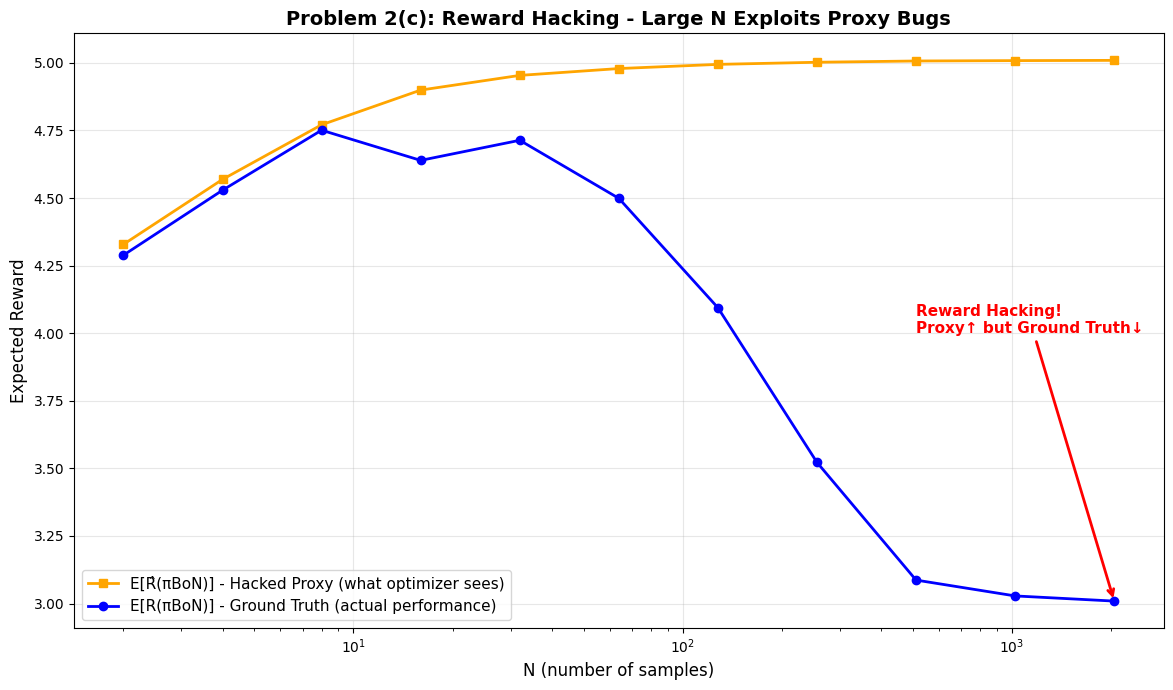


OBSERVATIONS:
1. At small N: Both rewards increase (finding outputs near x=2)
2. At large N: Proxy reward continues increasing, but ground truth DECREASES!
3. This happens because Best-of-N exploits the boundary bug at [0,0.01] and [3.99,4]
4. Why large N is bad: It amplifies exploitation of proxy errors/bugs


In [12]:
# Problem 2(c): Reward Hacking - Proxy vs Ground Truth

def estimate_reward_hacked(n: int) -> tuple[float, float]:
    """
    Use HACKED PROXY for selection, but evaluate with both:
    - Hacked proxy reward (what optimizer thinks)
    - Ground truth reward (actual performance)
    """
    total_reward_proxy = 0.0
    total_reward_ground_truth = 0.0
    num_trials = 100  # As specified in homework
    
    for _ in range(num_trials):
        # Select using hacked proxy
        best_output, reward_proxy = best_of_n(n, reward_model_proxy_hacked)
        
        # Evaluate the same output with ground truth
        reward_gt = reward_model_ground_truth(best_output)
        
        total_reward_proxy += reward_proxy
        total_reward_ground_truth += reward_gt
    
    return total_reward_proxy / num_trials, total_reward_ground_truth / num_trials

print("Problem 2(c): Reward Hacking Demonstration")
print("=" * 70)

rewards_proxy_hacked: list[float] = []
rewards_ground_truth_hacked: list[float] = []

RANGE_N_LARGE: list[int] = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048]

for n in RANGE_N_LARGE:
    reward_proxy, reward_gt = estimate_reward_hacked(n)
    rewards_proxy_hacked.append(reward_proxy)
    rewards_ground_truth_hacked.append(reward_gt)
    print(f"N={n:4d}, E[R̂]={reward_proxy:.4f}, E[R]={reward_gt:.4f}, Δ={reward_proxy - reward_gt:.4f}")

# Plot the reward hacking phenomenon
plt.figure(figsize=(12, 7))
plt.plot(RANGE_N_LARGE, rewards_proxy_hacked, marker='s', linewidth=2, 
         label='E[R̂(πBoN)] - Hacked Proxy (what optimizer sees)', color='orange')
plt.plot(RANGE_N_LARGE, rewards_ground_truth_hacked, marker='o', linewidth=2, 
         label='E[R(πBoN)] - Ground Truth (actual performance)', color='blue')

plt.xscale('log')
plt.xlabel('N (number of samples)', fontsize=12)
plt.ylabel('Expected Reward', fontsize=12)
plt.title('Problem 2(c): Reward Hacking - Large N Exploits Proxy Bugs', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

# Add annotation for the divergence
max_idx = RANGE_N_LARGE.index(max(RANGE_N_LARGE))
plt.annotate('Reward Hacking!\nProxy↑ but Ground Truth↓', 
             xy=(RANGE_N_LARGE[max_idx], rewards_ground_truth_hacked[max_idx]),
             xytext=(RANGE_N_LARGE[max_idx]//4, 4.0),
             arrowprops=dict(arrowstyle='->', color='red', lw=2),
             fontsize=11, color='red', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n" + "=" * 70)
print("OBSERVATIONS:")
print("1. At small N: Both rewards increase (finding outputs near x=2)")
print("2. At large N: Proxy reward continues increasing, but ground truth DECREASES!")
print("3. This happens because Best-of-N exploits the boundary bug at [0,0.01] and [3.99,4]")
print("4. Why large N is bad: It amplifies exploitation of proxy errors/bugs")
print("=" * 70)